Creating API key

In [ ]:
!pip3 install -q kaggle
!pip3 install torch_geometric

In [106]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, TransformerConv, GATv2Conv, ChebConv, ResGatedGraphConv, GAT
import torch_geometric.nn as pyg_nn
from torch_geometric.loader import DataLoader

In [3]:
from google.colab import files
files.upload() #just load your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aaanikit","key":"20cd3080d6b8628fef8a299dd1101ec7"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download data

In [ ]:
!kaggle datasets download -d origamik/united-airlines-call-center-sentiment-dataset
!kaggle datasets download -d takuok/glove840b300dtxt
!unzip "united-airlines-call-center-sentiment-dataset.zip"
!unzip "glove840b300dtxt.zip"

Data processing

In [6]:
import pandas as pd

calls_df = pd.read_csv('calls.csv')
sentiment_df = pd.read_csv('sentiment_statistics.csv')

# union of 2 dataframes by call_id
merged_df = pd.merge(calls_df, sentiment_df, on="call_id", how="inner")

# drop useless columns
columns_to_drop = [
    "call_id",
    "customer_id",
    "agent_tone",
    "average_sentiment",
    "silence_percent_average",
    "agent_id_x",
    "call_start_datetime",
    "agent_assigned_datetime",
    "call_end_datetime",
    "agent_id_y"
]

final_df = merged_df.drop(columns=columns_to_drop, errors='ignore')
final_df.to_csv("merged_output.csv", index=False)

In [7]:
final_df.head()

,call_transcript,customer_tone
0,\n\nAgent: Thank you for calling United Airlin...,angry
1,\n\nAgent: Thank you for calling United Airlin...,neutral
2,\n\nAgent: Thank you for calling United Airlin...,polite
3,\n\nAgent: Thank you for calling United Airlin...,frustrated
4,\n\nAgent: Thank you for calling United Airlin...,polite


make the label encoder

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(final_df.customer_tone)
final_df['customer_tone'] = le.transform(final_df.customer_tone)

обрезаем датасет, т.к. слишком большие размеры


In [12]:
final_df = final_df[:3000]

распределение классов

<ipython-input-66-cba32311dbb7>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x='customer_tone', palette='viridis')


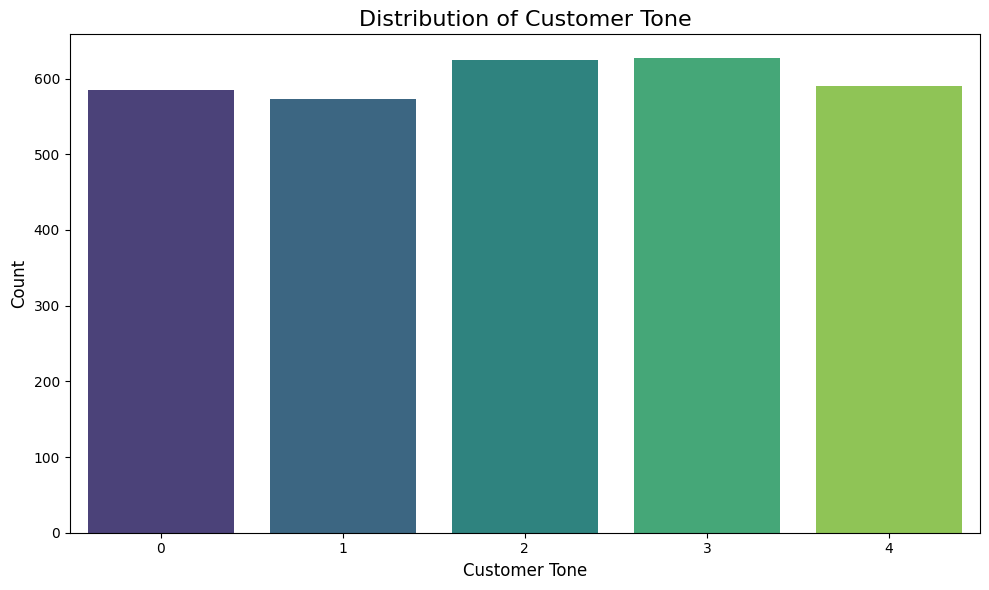

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming final_df is your DataFrame
# final_df = pd.read_csv("your_data.csv")  # Uncomment and modify if you're loading from a CSV

# Create a count plot for 'customer_tone' distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=final_df, x='customer_tone', palette='viridis')

# Set plot labels and title
plt.title('Distribution of Customer Tone', fontsize=16)
plt.xlabel('Customer Tone', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


в целом все распределено примерно равномерно, будем использовать accuracy как метрику

Определяем токенайзер

- Инициализация: Класс загружает эмбеддинги из файла GloVe, добавляет специальные токены (unk, pad), если они указаны.
- Токенизация и преобразование: При помощи метода doc_to_sequence можно преобразовать строку текста в числовые индексы, которые затем можно использовать.

In [13]:
import spacy
from spacy.tokens import Doc
from spacy import displacy
from scipy.sparse import coo_matrix


class Tokenizer(object):
    def __init__(self, word2idx=None, nlp_model="en_core_web_sm"):
        # https://spacy.io/docs/usage/processing-text
        self.nlp = spacy.load(nlp_model)
        if word2idx is None:
            self.word2idx = {}
            self.idx2word = {}
            self.idx = 0
            self.word2idx['<pad>'] = self.idx  # '<pad>': 0
            self.idx2word[self.idx] = '<pad>'
            self.idx += 1
            self.word2idx['<unk>'] = self.idx  # '<unk>': 1
            self.idx2word[self.idx] = '<unk>'
            self.idx += 1
        else:
            self.word2idx = word2idx
            self.idx2word = {v:k for k,v in word2idx.items()}

    def fit_on_doc(self, doc:spacy.tokens.doc.Doc):
        for word in doc:
            word = str(word).lower()
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def text_to_doc(self, text):
        return self.nlp(text)

    def doc_to_sequence(self, doc:spacy.tokens.doc.Doc):
        sequence = []
        for w in doc:
            w = str(w).lower()
            word_id = self.word2idx.get(w, -1)
            if word_id == -1:
                word_id = self.word2idx['<unk>']
            sequence.append(word_id)
        if len(sequence) == 0:
            sequence = [0]
        return np.array(sequence, dtype=np.int32)

    def doc_to_adj(self, doc:spacy.tokens.doc.Doc):
        matrix = np.zeros((len(doc), len(doc))).astype('int32')
        for token in doc:
            for child in token.children:
                matrix[token.i][child.i] = 1
                matrix[child.i][token.i] = 1
        return matrix

In [14]:
from tqdm import tqdm
import numpy as np

tokenizer = Tokenizer()

idx2graph = {}
for i in tqdm(range(final_df.shape[0])):
    text = final_df.call_transcript[i].lower().replace("\n", "").strip()
    doc = tokenizer.text_to_doc(text)
    tokenizer.fit_on_doc(doc)
    adj_matrix = tokenizer.doc_to_adj(doc)
    coo = coo_matrix(adj_matrix)
    idx2graph[i] = np.array([coo.row, coo.col], dtype=np.int32)

100%|██████████| 3000/3000 [07:01<00:00,  7.12it/s]


Example of knoledge graph

In [16]:
final_df['call_transcript'][50]

"\n\nAgent: Thank you for calling United Airlines customer service, my name is Sarah how can I help you?\n\nCustomer: Hi, I'm calling to complain about my missing luggage from flight 123 yesterday. I landed and my bag was nowhere to be found. It's been over 24 hours now and I still don't have it!\n\nAgent: I'm sorry to hear that. Can you confirm your name and flight details for me please so I can take a look into this? \n\nCustomer: It's John Smith, flight number 123 from New York to San Francisco, I arrived yesterday at 5pm. \n\nAgent: Thanks, just let me pull up your record... *typing noises* okay I see the flight information here. It looks like your bag was delayed in transferring from the inbound flight. These things unfortunately happen sometimes with connecting flights. Let me check the status... it looks like your bag is still at JFK airport waiting to come out on the next flight today. I apologize for the inconvenience. \n\nCustomer: Are you kidding me? Waiting until today? I'v

In [ ]:
doc = tokenizer.text_to_doc(final_df['call_transcript'][50])
tokenizer.doc_to_sequence(doc)

In [18]:
text = final_df.call_transcript[1].lower().replace("\n", "").strip()
doc = tokenizer.nlp(text)
displacy.render(doc, style='dep', jupyter=True)

In [20]:
def load_word_vec(path, word2idx=None, embed_dim=300):
    fin = open(path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    word_vec = {}
    for line in fin:
        tokens = line.rstrip().split()
        word, vec = ' '.join(tokens[:-embed_dim]), tokens[-embed_dim:]
        if word in word2idx.keys():
            word_vec[word] = np.array(vec, dtype=np.float32)
    return word_vec


def build_embedding_matrix(word2idx, embed_dim=300):
    embedding_matrix = np.zeros((len(word2idx), embed_dim))
    embedding_matrix[1, :] = np.random.uniform(-1/np.sqrt(embed_dim), 1/np.sqrt(embed_dim), (1, embed_dim))

    fname = 'glove.840B.300d.txt'
    word_vec = load_word_vec(fname, word2idx=word2idx, embed_dim=embed_dim)

    for word, i in word2idx.items():
        vec = word_vec.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

    return embedding_matrix

embedding_matrix = build_embedding_matrix(tokenizer.word2idx, 300)

In [33]:
embedding_matrix.shape

(12732, 300)

теперь готовы эмбеддинги для каждой записи

In [21]:
#!mkdir raw
!mv customers.csv /raw

In [24]:
import os

class MyTrainDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.process()
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return "customers.csv"

    @property
    def processed_dir(self):
        return os.path.join(self.root, "train_processed")

    @property
    def raw_file_names(self):
        return ['train.csv']

    @property
    def processed_file_names(self):
        return ['train-data.pt']

    def download(self):
        pass

    def process(self):
        data_list = self.read_data()


        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]


        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def read_data(self):
        print("reading the dataframe")
        df_train = final_df
        all_data = []

        for i in range(df_train.shape[0]):
            text = df_train.call_transcript.iloc[i].lower().replace("\n", "").strip()
            doc = tokenizer.text_to_doc(text)
            input_ids = tokenizer.doc_to_sequence(doc)
            label = df_train.customer_tone.iloc[i]

            x = torch.tensor(input_ids, dtype=torch.int32).unsqueeze(1)
            edge_index = torch.tensor(idx2graph[i], dtype=torch.long)
            y = torch.tensor([label], dtype=torch.float32)


            data = Data(x=x, edge_index=edge_index, y=y)
            all_data.append(data)

        return all_data


In [25]:
dataset = MyTrainDataset(root='/content')

Processing...


reading the dataframe


Done!


reading the dataframe


<ipython-input-24-2d17be14ba81>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


splitting the graph dataset to train and test, making pytorch dataloader

In [26]:
dataset = dataset.shuffle()
train_len = int(0.8*len(dataset))
train_dataset, val_dataset = dataset[:train_len], dataset[train_len:]

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def make_plot(train_loss_full, test_loss_full):
    phase1 = train_loss_full
    phase2 = test_loss_full

    iterations_train, iterations_test = np.arange(len(phase1)), np.arange(len(phase2))

    # Phase 1 end index
    phase1_end = len(phase1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plotting for Training Loss (only Phase 1)
    ax1.plot(iterations_train, phase1, color='green', linewidth=2)
    ax1.fill_between(iterations_train, phase1, color='green', alpha=0.1)
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss Value")
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper right')

    # Plotting for Test Loss (only Phase 1)
    ax2.plot(iterations_test, phase2, color='purple', linewidth=2)
    ax2.fill_between(iterations_test, phase2, color='purple', alpha=0.1)
    ax2.set_title("Test Loss")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss Value")
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.legend(loc='upper right')

    # Add text for RMSE values (min RMSE of each phase)
    text1 = f"Minimum of the cross-entropy - {min(phase1):.3f}\n"
    ax1.text(0.99, 0.84, text1, transform=ax1.transAxes, fontsize=12,
            color='black', ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [98]:
from sklearn.metrics import accuracy_score

def training():
    train_loss, test_loss = [], []
    train_loss_full, test_loss_full = [], []

    for epoch_num in range(1, epochs+1):
        model.train()
        total_loss = []
        for i, sample_batched in enumerate(train_loader):
            sample_batched = sample_batched.to(device)
            optimizer.zero_grad()
            outputs = model(sample_batched)
            label = sample_batched.y.to(device)
            loss = criterion(outputs, label.to(torch.long))
            loss.backward()
            train_loss += [loss.item()]; train_loss_full += [loss.item()]
            optimizer.step()

        model.eval()
        total_loss_val = 0

        true_labels, preds_labels = [], []
        with torch.no_grad():
            for sample_batched in val_loader:
                sample_batched = sample_batched.to(device)
                outputs = model(sample_batched)
                label = sample_batched.y.to(device)
                true_labels += label.numpy().tolist()
                answers = torch.argmax(outputs, dim=1)
                preds_labels += answers.numpy().tolist()
                loss = criterion(outputs, label.to(torch.long))
                test_loss += [loss.item()]; test_loss_full += [loss.item()]

        acc = accuracy_score(true_labels, preds_labels)
        print(f'Epoch: {epoch_num} | train avg loss: {sum(train_loss) / len(train_loss): .3f} | test avg loss: {sum(test_loss) / len(test_loss): .3f} | test accuracy: {acc:.3f}')

    return train_loss_full, test_loss_full

# Graph convolution model

In [27]:
class GCNConvModel(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()

        self.embed = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.gc1   = GCNConv(300, 128)
        self.pool1 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.gc2   = GCNConv(128, 128)
        self.pool2 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.lin1  = nn.Linear(256, 64)
        self.lin2  = nn.Linear(64, 5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1)
        x = self.embed(x)

        x = F.relu(self.gc1(x, edge_index))
        x, edge_index, edge_attr, batch, perm, score = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.gc2(x, edge_index))
        x, edge_index, edge_attr, batch, perm, score = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = x1 + x2
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        output = F.relu(self.lin2(x))

        return output

In [100]:
model = GCNConvModel(embedding_matrix)

epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [101]:
train_loss_full, test_loss_full = training()

Epoch: 1 | train avg loss:  1.591 | test avg loss:  1.449 | test accuracy: 0.333
Epoch: 2 | train avg loss:  1.445 | test avg loss:  1.265 | test accuracy: 0.485
Epoch: 3 | train avg loss:  1.311 | test avg loss:  1.165 | test accuracy: 0.488
Epoch: 4 | train avg loss:  1.226 | test avg loss:  1.110 | test accuracy: 0.487
Epoch: 5 | train avg loss:  1.161 | test avg loss:  1.081 | test accuracy: 0.483
Epoch: 6 | train avg loss:  1.112 | test avg loss:  1.054 | test accuracy: 0.520
Epoch: 7 | train avg loss:  1.070 | test avg loss:  1.037 | test accuracy: 0.502
Epoch: 8 | train avg loss:  1.032 | test avg loss:  1.035 | test accuracy: 0.487
Epoch: 9 | train avg loss:  0.995 | test avg loss:  1.032 | test accuracy: 0.510
Epoch: 10 | train avg loss:  0.961 | test avg loss:  1.040 | test accuracy: 0.505
Epoch: 11 | train avg loss:  0.928 | test avg loss:  1.069 | test accuracy: 0.475
Epoch: 12 | train avg loss:  0.899 | test avg loss:  1.097 | test accuracy: 0.490
Epoch: 13 | train avg los

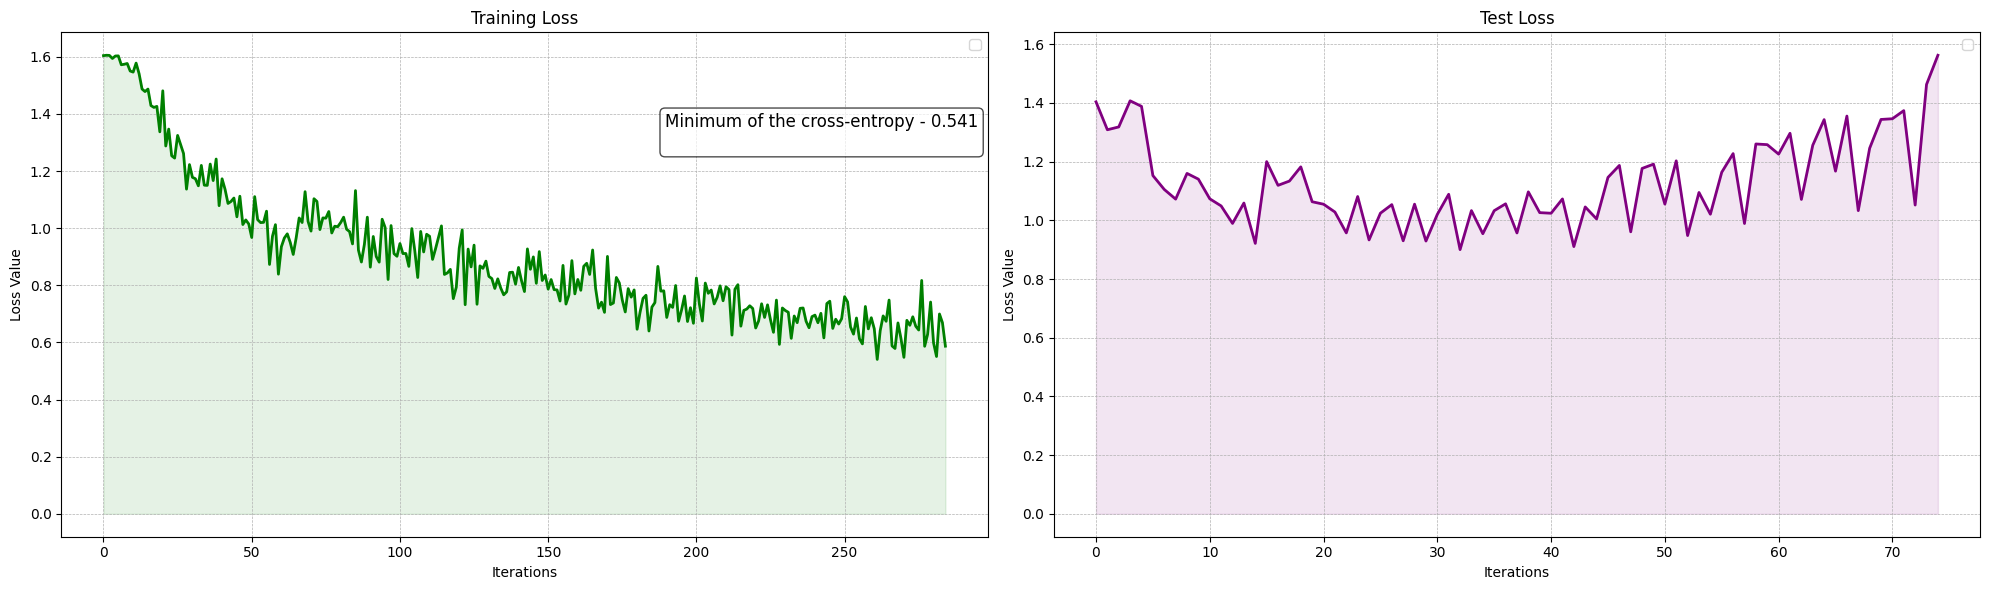

In [45]:
make_plot(train_loss_full, test_loss_full)

видим офверфиттинг примерно с 7ой эпохи

# Graph Attention model with GATv2 from https://arxiv.org/abs/2105.14491

In [93]:
class GraphAttentionModel(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()

        self.embed = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.gc1   = GATv2Conv(300, 128)
        self.pool1 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.gc2   = GATv2Conv(128, 128)
        self.pool2 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.lin1  = nn.Linear(256, 64)
        self.lin2  = nn.Linear(64, 5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1)
        x = self.embed(x)

        x = F.relu(self.gc1(x, edge_index))
        x, edge_index, edge_attr, batch, perm, score = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.gc2(x, edge_index))
        x, edge_index, edge_attr, batch, perm, score = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = x1 + x2
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        output = F.relu(self.lin2(x))

        return output

In [94]:
model = GraphAttentionModel(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=3e-3)

In [95]:
train_loss_full, test_loss_full = training()

Epoch: 1 | train avg loss:  1.609 | test avg loss:  1.595 | test accuracy: 0.318
Epoch: 2 | train avg loss:  1.553 | test avg loss:  1.492 | test accuracy: 0.332
Epoch: 3 | train avg loss:  1.457 | test avg loss:  1.408 | test accuracy: 0.470
Epoch: 4 | train avg loss:  1.384 | test avg loss:  1.357 | test accuracy: 0.468
Epoch: 5 | train avg loss:  1.326 | test avg loss:  1.336 | test accuracy: 0.465
Epoch: 6 | train avg loss:  1.265 | test avg loss:  1.346 | test accuracy: 0.450
Epoch: 7 | train avg loss:  1.210 | test avg loss:  1.359 | test accuracy: 0.438
Epoch: 8 | train avg loss:  1.162 | test avg loss:  1.377 | test accuracy: 0.418
Epoch: 9 | train avg loss:  1.119 | test avg loss:  1.407 | test accuracy: 0.440
Epoch: 10 | train avg loss:  1.080 | test avg loss:  1.426 | test accuracy: 0.402
Epoch: 11 | train avg loss:  1.046 | test avg loss:  1.469 | test accuracy: 0.423
Epoch: 12 | train avg loss:  1.015 | test avg loss:  1.494 | test accuracy: 0.432
Epoch: 13 | train avg los

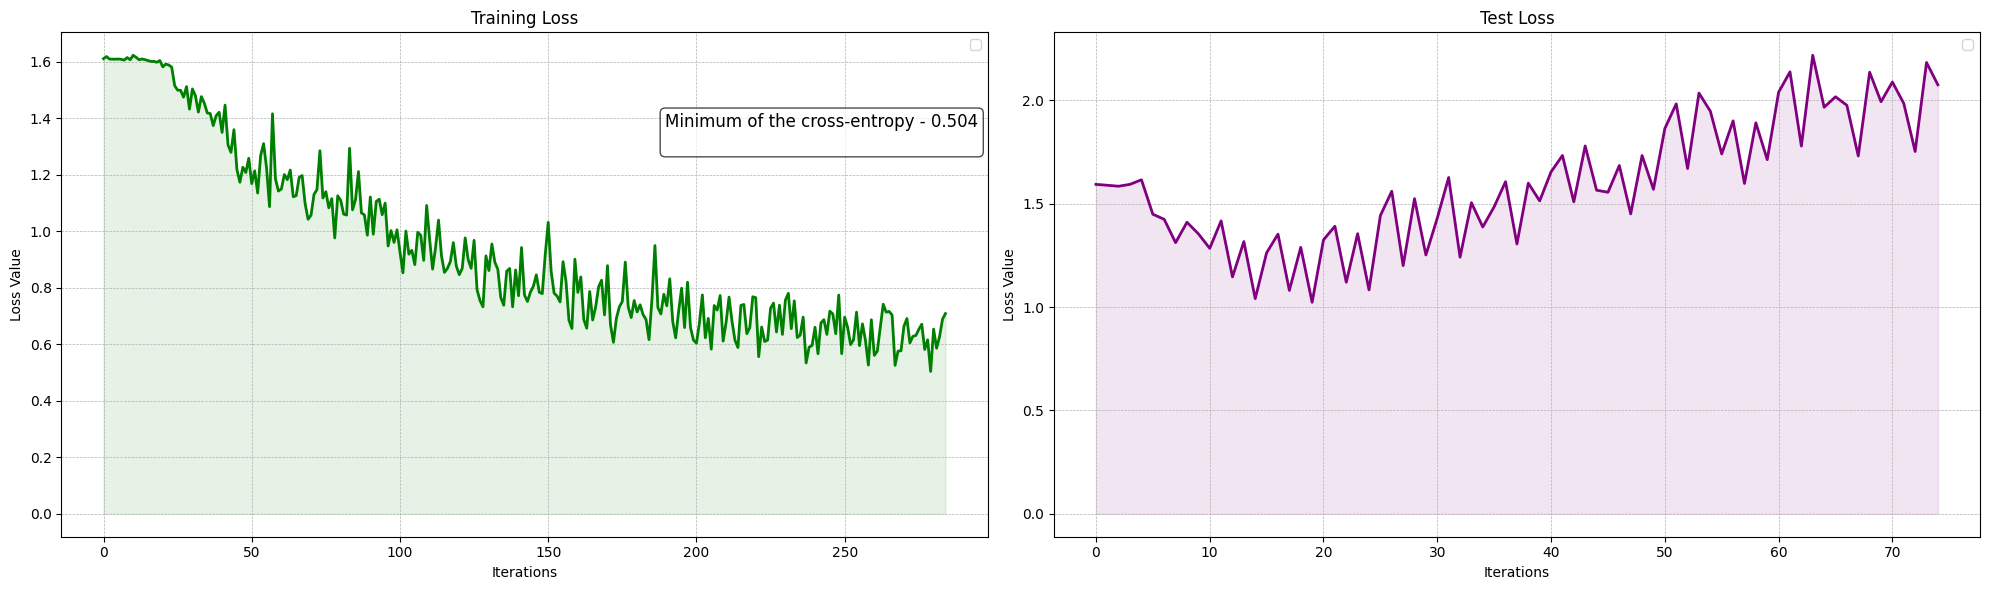

In [99]:
make_plot(train_loss_full, test_loss_full)

лучший accuracy - 0.468, довольно быстрое начало оверфиттинга

# Model with plain GAT

In [112]:
class GraphAttentionModelv1(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()

        self.embed = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.gc1   = GAT(300, 128, num_layers=5)
        self.pool1 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.gc2   = GAT(128, 128, num_layers=5)
        self.pool2 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.lin1  = nn.Linear(256, 64)
        self.lin2  = nn.Linear(64, 5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1)
        x = self.embed(x)

        x = F.relu(self.gc1(x, edge_index))
        x, edge_index, edge_attr, batch, perm, score = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.gc2(x, edge_index))
        x, edge_index, edge_attr, batch, perm, score = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = x1 + x2
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        output = F.relu(self.lin2(x))

        return output

In [113]:
model = GraphAttentionModelv1(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=3e-3)

In [ ]:
train_loss_full, test_loss_full = training()

Epoch: 1 | train avg loss:  1.610 | test avg loss:  1.607 | test accuracy: 0.218
